# Preprocessing of Image Data for Convolutional Neural Net

## This approach was adopted from the following guide: [link](https://deeplizard.com/learn/video/LhEMXbjGV_4)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import time
%matplotlib inline

In [2]:
home_dir = os.getcwd()

In [3]:
n_samples_train = 500
n_samples_valid = 100
n_samples_test = 50

In [2]:
# Organize data into train, valid, test dirs
print(f'Current Working Directory: {os.getcwd()}')
os.chdir('./data/')

if os.path.isdir('train_test_split') is False:
    os.makedirs('train_test_split')

os.chdir('./train_test_split')
    
if os.path.isdir('train/real') is False:
    os.makedirs('train/real')
    os.makedirs('train/synthetic')
    os.makedirs('valid/real')
    os.makedirs('valid/synthetic')
    os.makedirs('test/real')
    os.makedirs('test/synthetic')
    
    os.chdir(f'{home_dir}/data/real/thumbnails128x128/')
    for i in random.sample(glob.glob('*'), n_samples_train):
        shutil.copy(i, f'{home_dir}/data/train_test_split/train/real')
    for i in random.sample(glob.glob('*'), n_samples_valid):
        shutil.copy(i, f'{home_dir}/data/train_test_split/valid/real')
    for i in random.sample(glob.glob('*'), n_samples_test):
        shutil.copy(i, f'{home_dir}/data/train_test_split/test/real') 
        
    os.chdir(f'{home_dir}/data/generated/Low Res')
    for i in random.sample(glob.glob('*'), n_samples_train):
        shutil.copy(i, f'{home_dir}/data/train_test_split/train/synthetic')        
    for i in random.sample(glob.glob('*'), n_samples_valid):
        shutil.copy(i, f'{home_dir}/data/train_test_split/valid/synthetic')
    for i in random.sample(glob.glob('*'), n_samples_test):
        shutil.copy(i, f'{home_dir}/data/train_test_split/test/synthetic')

os.chdir(home_dir)

Current Working Directory: C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask


In [10]:
os.getcwd()

'C:\\Users\\musou\\Documents\\GeneralAssembly\\DSI\\Projects\\deepfake-unmask'

In [11]:
train_path = './data/train_test_split/train/'
valid_path = './data/train_test_split/valid'
test_path = './data/train_test_split/test'

In [12]:
n_batch = 10
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
imgs, labels = next(train_batches)

In [4]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
#         ax.imshow(img) # original code; was getting warnings about clipping
        ax.imshow((img * 255).astype(np.uint8)) # updated imshow to address clipping issues
        ax.axis('off')
    plt.tight_layout()
    plt.show()

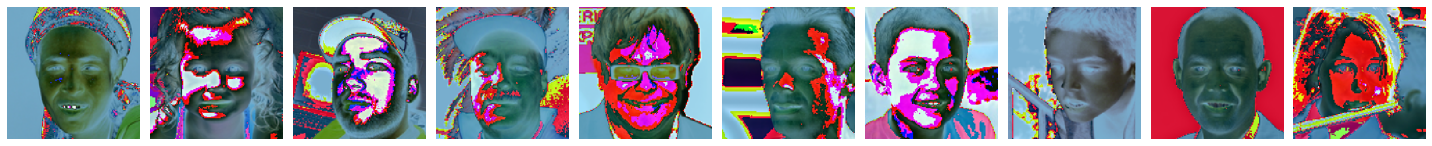

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [8]:
plotImages(imgs)
print(labels);

# Neural Net

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# if physical_devices:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [6]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [14]:
n_samples_train//n_batch

50

In [16]:
time_0 = time.time()

model.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/10
50/50 [==============================] - 9s 176ms/step - loss: 5.0232 - accuracy: 0.7400 - val_loss: 3.7646 - val_accuracy: 0.7600
Epoch 2/10
50/50 [==============================] - 5s 103ms/step - loss: 3.3389 - accuracy: 0.7920 - val_loss: 4.8551 - val_accuracy: 0.6900
Epoch 3/10
50/50 [==============================] - 4s 85ms/step - loss: 1.5192 - accuracy: 0.8460 - val_loss: 3.0803 - val_accuracy: 0.7000
Epoch 4/10
50/50 [==============================] - 4s 83ms/step - loss: 0.8555 - accuracy: 0.9080 - val_loss: 3.0497 - val_accuracy: 0.7000
Epoch 5/10
50/50 [==============================] - 4s 82ms/step - loss: 0.9861 - accuracy: 0.8700 - val_loss: 1.8305 - val_accuracy: 0.7800
Epoch 6/10
50/50 [==============================] - 4s 80ms/step - loss: 0.4217 - accuracy: 0.9360 - val_loss: 1.7738 - val_accuracy: 0.8300
Epoch 7/10
50/50 [==============================] - 4s 80ms/step - loss: 0.2223 - accuracy: 0.9560 - val_loss: 1.3272 - val_accuracy: 0.8100
Epoch 8/10


In [17]:
model.history.history

{'loss': [5.023240566253662,
  3.338935375213623,
  1.5191779136657715,
  0.8555397391319275,
  0.986149251461029,
  0.4217178523540497,
  0.22230394184589386,
  0.11094852536916733,
  0.06450715661048889,
  0.025092067196965218],
 'accuracy': [0.7400000095367432,
  0.7919999957084656,
  0.8460000157356262,
  0.9079999923706055,
  0.8700000047683716,
  0.9359999895095825,
  0.9559999704360962,
  0.9800000190734863,
  0.9919999837875366,
  0.9900000095367432],
 'val_loss': [3.764592170715332,
  4.855078220367432,
  3.0803003311157227,
  3.049715995788574,
  1.8305386304855347,
  1.7737737894058228,
  1.3272045850753784,
  1.3369345664978027,
  0.9490182399749756,
  1.7358440160751343],
 'val_accuracy': [0.7599999904632568,
  0.6899999976158142,
  0.699999988079071,
  0.699999988079071,
  0.7799999713897705,
  0.8299999833106995,
  0.8100000023841858,
  0.8100000023841858,
  0.800000011920929,
  0.7599999904632568]}

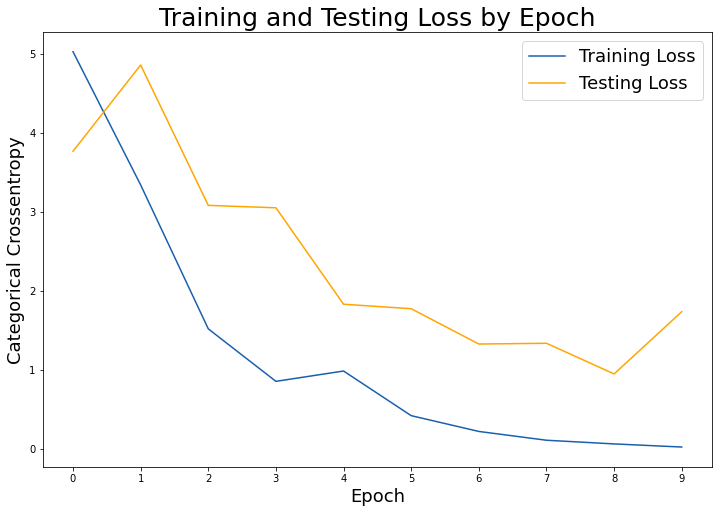

In [18]:
# plotting per https://git.generalassemb.ly/DSIR-0124/lesson-cnn/blob/master/starter-code-fast-cpu.ipynb

# Check out our train loss and test loss over epochs.
train_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']
epoch_labels = model.history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

## Testing the difference in performance when real and synthetic images have been passed through the same interpolation for downscaling

In [19]:
os.getcwd()

'C:\\Users\\musou\\Documents\\GeneralAssembly\\DSI\\Projects\\deepfake-unmask'

In [20]:
# Function for moving data into train, valid, test dirs

def img_train_test(split_dir, real_dir, synth_dir, n_samples_train=500, n_samples_valid=100, n_samples_test=50):
    
    print(f'Current Working Directory: {os.getcwd()}')
    home_dir = os.getcwd()

    n_samples_train = n_samples_train
    n_samples_valid = n_samples_valid
    n_samples_test = n_samples_test

    if os.path.isdir(home_dir + split_dir) is False:
        os.makedirs(home_dir + split_dir)
    
    full_dir = (home_dir + split_dir)
    
    os.chdir(full_dir)
    if os.path.isdir('train/real') is False:
        os.makedirs('train/real')
        os.makedirs('train/synthetic')
        os.makedirs('valid/real')
        os.makedirs('valid/synthetic')
        os.makedirs('test/real')
        os.makedirs('test/synthetic')

#         os.chdir(home_dir + real_dir)
        for i in random.sample(glob.glob('*'), n_samples_train):
            shutil.copy(i, f'{home_dir}{split_dir}/train/real')
        for i in random.sample(glob.glob('*'), n_samples_valid):
            shutil.copy(i, f'{home_dir}{split_dir}/valid/real')
        for i in random.sample(glob.glob('*'), n_samples_test):
            shutil.copy(i, f'{home_dir}{split_dir}/test/real') 

#         os.chdir(home_dir + synth_dir)
        for i in random.sample(glob.glob('*'), n_samples_train):
            shutil.copy(i, f'{home_dir}{split_dir}/train/synthetic')        
        for i in random.sample(glob.glob('*'), n_samples_valid):
            shutil.copy(i, f'{home_dir}{split_dir}/valid/synthetic')
        for i in random.sample(glob.glob('*'), n_samples_test):
            shutil.copy(i, f'{home_dir}{split_dir}/test/synthetic')

    os.chdir(home_dir)

In [21]:
split_dir = '/data/INTER_AREA/train_test_split'
real_dir = '/data/real/FFHQ-high-res/INTER_AREA'
synth_dir = '/data/generated/Low Res'

In [22]:
os.path.normpath(home_dir + split_dir)

'C:\\Users\\musou\\Documents\\GeneralAssembly\\DSI\\Projects\\deepfake-unmask\\data\\INTER_AREA\\train_test_split'

In [23]:
img_train_test(split_dir, real_dir, synth_dir)

Current Working Directory: C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask


In [24]:
train_path = f'{home_dir}{split_dir}/train'
valid_path = f'{home_dir}{split_dir}/valid'
test_path = f'{home_dir}{split_dir}/test'

In [25]:
print(train_path + '\n' + valid_path + '\n' + test_path)

C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask/data/INTER_AREA/train_test_split/train
C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask/data/INTER_AREA/train_test_split/valid
C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask/data/INTER_AREA/train_test_split/test


In [26]:
n_batch = 10
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [27]:
model_inter_area = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [28]:
model_inter_area.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [29]:
model_inter_area.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
time_0 = time.time()

model_inter_area.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/10
50/50 [==============================] - 10s 201ms/step - loss: 14.3213 - accuracy: 0.6500 - val_loss: 3.1577 - val_accuracy: 0.6900
Epoch 2/10
50/50 [==============================] - 6s 117ms/step - loss: 3.1258 - accuracy: 0.7400 - val_loss: 2.0980 - val_accuracy: 0.7400
Epoch 3/10
50/50 [==============================] - 5s 86ms/step - loss: 1.5441 - accuracy: 0.7800 - val_loss: 1.0861 - val_accuracy: 0.8500
Epoch 4/10
50/50 [==============================] - 4s 83ms/step - loss: 1.2647 - accuracy: 0.8460 - val_loss: 1.1230 - val_accuracy: 0.8700
Epoch 5/10
50/50 [==============================] - 4s 81ms/step - loss: 0.5330 - accuracy: 0.9060 - val_loss: 0.9840 - val_accuracy: 0.8600
Epoch 6/10
50/50 [==============================] - 4s 80ms/step - loss: 0.3406 - accuracy: 0.9440 - val_loss: 0.8892 - val_accuracy: 0.8700
Epoch 7/10
50/50 [==============================] - 4s 80ms/step - loss: 0.1680 - accuracy: 0.9620 - val_loss: 1.5743 - val_accuracy: 0.7900
Epoch 8/1

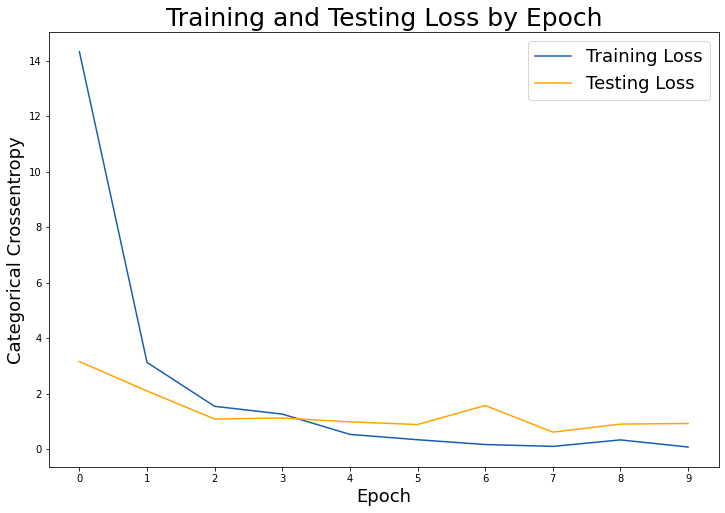

In [32]:
# plotting per https://git.generalassemb.ly/DSIR-0124/lesson-cnn/blob/master/starter-code-fast-cpu.ipynb

# Check out our train loss and test loss over epochs.
train_loss = model_inter_area.history.history['loss']
test_loss = model_inter_area.history.history['val_loss']
epoch_labels = model_inter_area.history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

### Model Predictions

In [33]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
test_batches.class_indices

{'real': 0, 'synthetic': 1}

In [35]:
test_batches.index_array

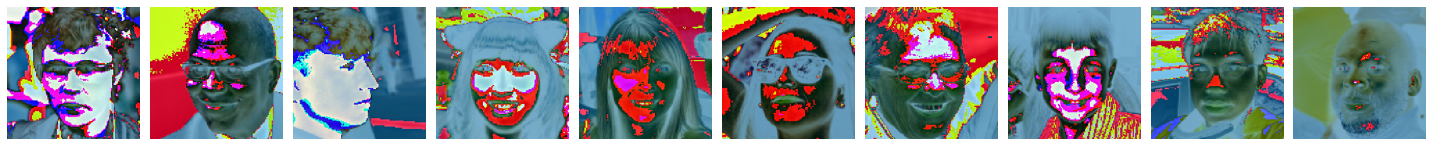

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [36]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [37]:
test_batches.batch_index

1

In [38]:
test_batches[0]

(array([[[[ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          [ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          [ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          ...,
          [-5.8939003e+01, -4.7778999e+01, -3.4680000e+01],
          [-5.8939003e+01, -4.7778999e+01, -3.5680000e+01],
          [-5.8939003e+01, -4.7778999e+01, -3.5680000e+01]],
 
         [[ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          [ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          [ 3.7060997e+01,  7.0221001e+01,  1.0432000e+02],
          ...,
          [-5.8939003e+01, -4.7778999e+01, -3.4680000e+01],
          [-5.8939003e+01, -4.7778999e+01, -3.5680000e+01],
          [-5.8939003e+01, -4.7778999e+01, -3.5680000e+01]],
 
         [[ 4.0060997e+01,  7.1221001e+01,  1.0532000e+02],
          [ 4.0060997e+01,  7.1221001e+01,  1.0532000e+02],
          [ 4.0060997e+01,  7.1221001e+01,  1.0532000e+02],
          ...,
          [-5.7939003e+01, -4.5778999e+01, -3.168

In [39]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
preds = model_inter_area.predict(x=test_batches, verbose=0)

In [41]:
preds[:10]

array([[9.9999905e-01, 9.4776914e-07],
       [1.0000000e+00, 3.5730014e-17],
       [1.0000000e+00, 5.3024781e-16],
       [9.9999940e-01, 5.8068849e-07],
       [9.9999976e-01, 2.2288677e-07],
       [9.9999928e-01, 6.8188098e-07],
       [1.0000000e+00, 1.6027467e-13],
       [9.9999988e-01, 9.5990210e-08],
       [1.0000000e+00, 3.6942849e-12],
       [1.0000000e+00, 2.6975965e-11]], dtype=float32)

In [42]:
bin_preds = np.argmax(preds, axis=-1)
bin_preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [43]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=bin_preds)

In [44]:
# copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[47  3]
 [ 5 45]]


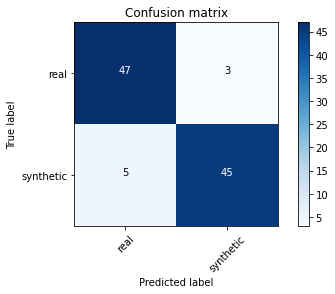

In [45]:
plot_confusion_matrix(cm, {'real': 0, 'synthetic': 1})

In [46]:
type(test_batches)

keras.preprocessing.image.DirectoryIterator

In [47]:
test_batches.index_array

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [48]:
true_classification = test_batches.classes
true_classification[0]

0

In [49]:
test_batches.batch_index

1

In [50]:
test_batches.classes - bin_preds

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1],
      dtype=int64)

In [51]:
test_batches.samples

100

In [52]:
def collect_missed_predictions(batch_iterator, predictions):
    incorrect_pred_idxs = []
    incorrect_preds = []
    delta = batch_iterator.classes - predictions
    for i in range(batch_iterator.samples):
        if delta[i] != 0:
            if delta[i] == -1:
                metric = 'False Positive'
            else:
                metric = 'False Negative'
            incorrect_pred_idxs.append((i, metric))
    
    return incorrect_pred_idxs

In [53]:
missed_predictions = collect_missed_predictions(test_batches, bin_preds)

In [54]:
missed_predictions

[(11, 'False Positive'),
 (18, 'False Positive'),
 (34, 'False Positive'),
 (52, 'False Negative'),
 (71, 'False Negative'),
 (77, 'False Negative'),
 (93, 'False Negative'),
 (99, 'False Negative')]

## Use pretrained model (VGG16)

In [358]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 59s 0us/step


In [361]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [365]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [366]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [367]:
for layer in model.layers:
    layer.trainable = False

In [368]:
model.add(Dense(units=2, activation='softmax'))

In [369]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [370]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [371]:
time_0 = time.time()

model.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=2, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/10
50/50 - 30s - loss: 0.8546 - accuracy: 0.5440 - val_loss: 0.6623 - val_accuracy: 0.6400 - 30s/epoch - 595ms/step
Epoch 2/10
50/50 - 20s - loss: 0.5997 - accuracy: 0.7080 - val_loss: 0.4882 - val_accuracy: 0.7700 - 20s/epoch - 406ms/step
Epoch 3/10
50/50 - 20s - loss: 0.5983 - accuracy: 0.7240 - val_loss: 0.5018 - val_accuracy: 0.8300 - 20s/epoch - 409ms/step
Epoch 4/10
50/50 - 20s - loss: 0.5170 - accuracy: 0.7600 - val_loss: 0.4693 - val_accuracy: 0.8200 - 20s/epoch - 405ms/step
Epoch 5/10
50/50 - 20s - loss: 0.5027 - accuracy: 0.7700 - val_loss: 0.4983 - val_accuracy: 0.7900 - 20s/epoch - 405ms/step
Epoch 6/10
50/50 - 20s - loss: 0.5218 - accuracy: 0.7440 - val_loss: 0.5046 - val_accuracy: 0.8000 - 20s/epoch - 402ms/step
Epoch 7/10
50/50 - 20s - loss: 0.4500 - accuracy: 0.7780 - val_loss: 0.5188 - val_accuracy: 0.7700 - 20s/epoch - 401ms/step
Epoch 8/10
50/50 - 20s - loss: 0.4186 - accuracy: 0.8260 - val_loss: 0.4871 - val_accuracy: 0.7800 - 20s/epoch - 396ms/step
Epoch 9/

Very interesting. This model is highly complex, and designed to distinguish between many types of objects/creatures. Although some of the features used to appropriately classify these targets are likely to be relevant/useful towards my ends, I suspect those features are drowned out by the enormous ammount of other features that simply don't apply when comparing two very similar, human shaped classes. I am going to proceed with tailoring my own, homegrown, model to the task.

In [56]:
# adding fully connected layers and dropout


model_inter_area_2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    
    Dense(128, activation='relu'), # added
    Dropout(.1), # added
    Dense(64, activation='relu'), # added
    Dropout(.1), # added
    
    Dense(units=2, activation='softmax')
])

model_inter_area_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_2.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/10
50/50 [==============================] - 7s 115ms/step - loss: 37.2638 - accuracy: 0.5260 - val_loss: 2.5149 - val_accuracy: 0.7100
Epoch 2/10
50/50 [==============================] - 5s 104ms/step - loss: 6.3480 - accuracy: 0.6200 - val_loss: 1.6151 - val_accuracy: 0.7400
Epoch 3/10
50/50 [==============================] - 5s 104ms/step - loss: 2.1311 - accuracy: 0.6920 - val_loss: 1.0485 - val_accuracy: 0.6700
Epoch 4/10
50/50 [==============================] - 5s 104ms/step - loss: 1.0890 - accuracy: 0.7600 - val_loss: 0.4639 - val_accuracy: 0.8400
Epoch 5/10
50/50 [==============================] - 5s 104ms/step - loss: 0.5691 - accuracy: 0.8100 - val_loss: 0.3629 - val_accuracy: 0.8300
Epoch 6/10
50/50 [==============================] - 5s 104ms/step - loss: 0.3753 - accuracy: 0.8380 - val_loss: 0.3386 - val_accuracy: 0.8400
Epoch 7/10
50/50 [==============================] - 5s 104ms/step - loss: 0.2900 - accuracy: 0.8680 - val_loss: 0.2449 - val_accuracy: 0.8900
Epoch

In [57]:
def get_confusion(model, test_data):
    preds = model.predict(x=test_data, verbose=0)
    bin_preds = np.argmax(preds, axis=-1)
    cm = confusion_matrix(y_true=test_data.classes, y_pred=bin_preds)
    plot_confusion_matrix(cm, {'real': 0, 'synthetic': 1})

In [58]:
# plotting per https://git.generalassemb.ly/DSIR-0124/lesson-cnn/blob/master/starter-code-fast-cpu.ipynb

def get_loss_vis(model):
    # Check out our train loss and test loss over epochs.
    train_loss = model.history.history['loss']
    test_loss = model.history.history['val_loss']
    epoch_labels = model.history.epoch

    # Set figure size.
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs.
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize=25)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Categorical Crossentropy', fontsize=18)
    plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

    plt.legend(fontsize=18);

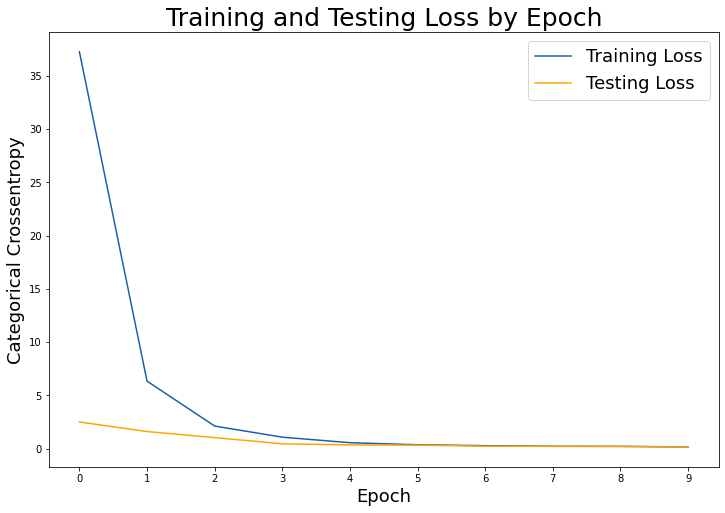

In [59]:
get_loss_vis(model_inter_area_2)

Confusion matrix, without normalization
[[43  7]
 [ 4 46]]


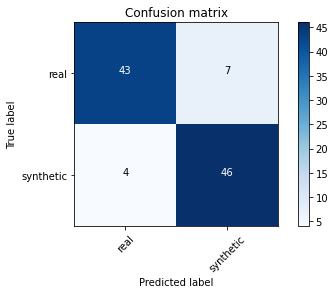

In [60]:
get_confusion(model_inter_area_2, test_batches)

In [61]:
# Adjusting dropout weight and increasing number of epochs


model_inter_area_3 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    
    Dense(128, activation='relu'), 
    Dropout(.2), # adjusted
    Dense(64, activation='relu'),
    Dropout(.2), # adjusted
    
    Dense(units=2, activation='softmax')
])

model_inter_area_3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_3.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=20, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/20
50/50 - 6s - loss: 32.5908 - accuracy: 0.5340 - val_loss: 3.6392 - val_accuracy: 0.6500 - 6s/epoch - 125ms/step
Epoch 2/20
50/50 - 5s - loss: 3.9712 - accuracy: 0.6580 - val_loss: 1.0066 - val_accuracy: 0.7600 - 5s/epoch - 102ms/step
Epoch 3/20
50/50 - 5s - loss: 0.9949 - accuracy: 0.6900 - val_loss: 0.4508 - val_accuracy: 0.7600 - 5s/epoch - 102ms/step
Epoch 4/20
50/50 - 5s - loss: 0.6114 - accuracy: 0.7420 - val_loss: 0.4887 - val_accuracy: 0.8000 - 5s/epoch - 101ms/step
Epoch 5/20
50/50 - 5s - loss: 0.5216 - accuracy: 0.7600 - val_loss: 0.4796 - val_accuracy: 0.7900 - 5s/epoch - 102ms/step
Epoch 6/20
50/50 - 5s - loss: 0.5101 - accuracy: 0.7560 - val_loss: 0.4150 - val_accuracy: 0.8300 - 5s/epoch - 102ms/step
Epoch 7/20
50/50 - 5s - loss: 0.4239 - accuracy: 0.7940 - val_loss: 0.4167 - val_accuracy: 0.8200 - 5s/epoch - 102ms/step
Epoch 8/20
50/50 - 5s - loss: 0.4151 - accuracy: 0.7940 - val_loss: 0.4215 - val_accuracy: 0.7700 - 5s/epoch - 102ms/step
Epoch 9/20
50/50 - 5s -

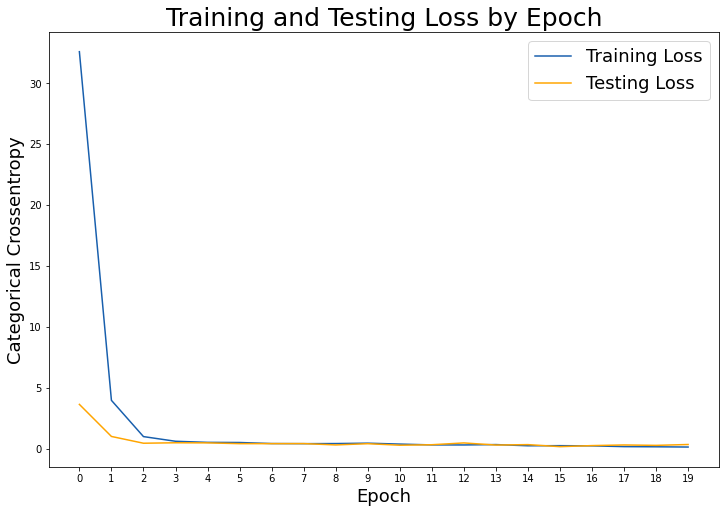

In [62]:
get_loss_vis(model_inter_area_3)

Confusion matrix, without normalization
[[45  5]
 [ 7 43]]


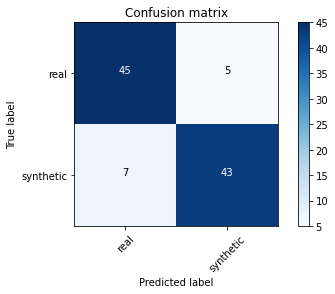

In [63]:
get_confusion(model_inter_area_3, test_batches)

In [64]:
# Adding additional convolution/pooling layer


model_inter_area_4 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'), # added
    MaxPool2D(pool_size=(2, 2), strides=2), # added
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.2),
    Dense(64, activation='relu'),
    Dropout(.2),
    
    Dense(units=2, activation='softmax')
])

model_inter_area_4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_4.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=20, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/20
50/50 [==============================] - 6s 95ms/step - loss: 3.8549 - accuracy: 0.5280 - val_loss: 0.6203 - val_accuracy: 0.7100
Epoch 2/20
50/50 [==============================] - 4s 85ms/step - loss: 0.9930 - accuracy: 0.5800 - val_loss: 0.5555 - val_accuracy: 0.7200
Epoch 3/20
50/50 [==============================] - 4s 85ms/step - loss: 0.7195 - accuracy: 0.6060 - val_loss: 0.5851 - val_accuracy: 0.6500
Epoch 4/20
50/50 [==============================] - 4s 85ms/step - loss: 0.5895 - accuracy: 0.7040 - val_loss: 0.4675 - val_accuracy: 0.8000
Epoch 5/20
50/50 [==============================] - 4s 86ms/step - loss: 0.6092 - accuracy: 0.7040 - val_loss: 0.4542 - val_accuracy: 0.7300
Epoch 6/20
50/50 [==============================] - 4s 85ms/step - loss: 0.5236 - accuracy: 0.7620 - val_loss: 0.4944 - val_accuracy: 0.8100
Epoch 7/20
50/50 [==============================] - 4s 85ms/step - loss: 0.5005 - accuracy: 0.7620 - val_loss: 0.4340 - val_accuracy: 0.8100
Epoch 8/20
50

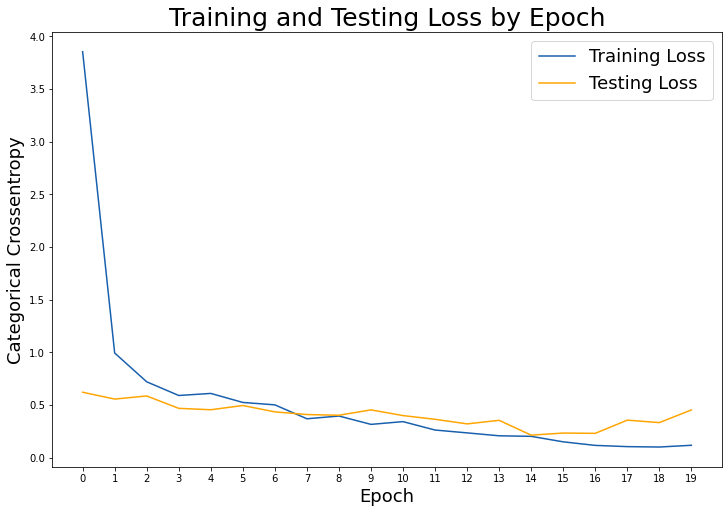

In [65]:
get_loss_vis(model_inter_area_4)

Confusion matrix, without normalization
[[45  5]
 [ 7 43]]


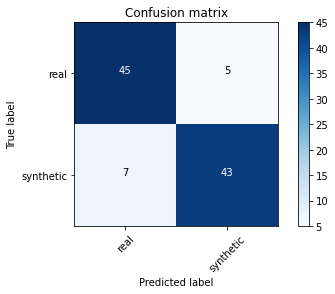

In [66]:
get_confusion(model_inter_area_4, test_batches)

In [67]:
# Increasing dropout rate to try and limit overfitting


model_inter_area_5 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.25), # adjusted
    Dense(64, activation='relu'),
    Dropout(.25), # adjusted
    
    Dense(units=2, activation='softmax')
])

model_inter_area_5.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_5.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=20, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/20
50/50 [==============================] - 6s 95ms/step - loss: 4.4573 - accuracy: 0.4980 - val_loss: 0.8174 - val_accuracy: 0.6000
Epoch 2/20
50/50 [==============================] - 4s 86ms/step - loss: 1.0127 - accuracy: 0.5820 - val_loss: 0.6035 - val_accuracy: 0.6800
Epoch 3/20
50/50 [==============================] - 4s 85ms/step - loss: 0.7144 - accuracy: 0.6160 - val_loss: 0.6534 - val_accuracy: 0.6000
Epoch 4/20
50/50 [==============================] - 4s 85ms/step - loss: 0.6212 - accuracy: 0.6620 - val_loss: 0.5715 - val_accuracy: 0.6800
Epoch 5/20
50/50 [==============================] - 4s 85ms/step - loss: 0.5997 - accuracy: 0.7060 - val_loss: 0.4974 - val_accuracy: 0.7800
Epoch 6/20
50/50 [==============================] - 4s 86ms/step - loss: 0.5258 - accuracy: 0.7360 - val_loss: 0.4434 - val_accuracy: 0.7600
Epoch 7/20
50/50 [==============================] - 4s 85ms/step - loss: 0.5118 - accuracy: 0.7780 - val_loss: 0.4844 - val_accuracy: 0.7700
Epoch 8/20
50

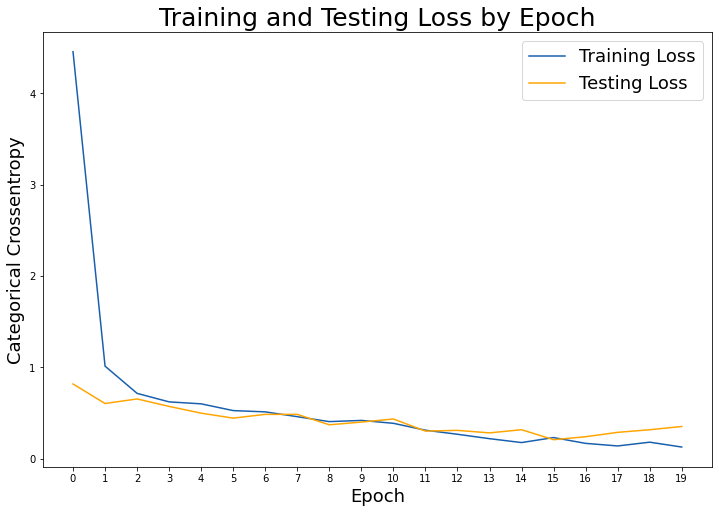

In [68]:
get_loss_vis(model_inter_area_5)

Confusion matrix, without normalization
[[46  4]
 [11 39]]


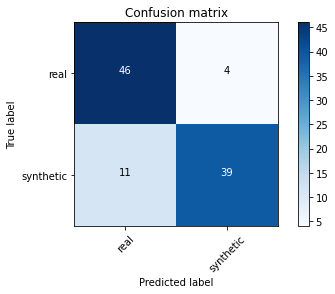

In [69]:
get_confusion(model_inter_area_5, test_batches)

In [73]:
# Increasing dropout rate to try and limit overfitting


model_inter_area_6 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.35), # adjusted
    Dense(64, activation='relu'),
    Dropout(.35), # adjusted
    
    Dense(units=2, activation='softmax')
])

model_inter_area_6.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_6.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=20, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/20
50/50 [==============================] - 6s 95ms/step - loss: 6.7103 - accuracy: 0.5260 - val_loss: 0.7503 - val_accuracy: 0.6000
Epoch 2/20
50/50 [==============================] - 4s 85ms/step - loss: 1.0105 - accuracy: 0.5700 - val_loss: 0.6160 - val_accuracy: 0.6700
Epoch 3/20
50/50 [==============================] - 4s 85ms/step - loss: 0.7657 - accuracy: 0.5920 - val_loss: 0.6182 - val_accuracy: 0.6800
Epoch 4/20
50/50 [==============================] - 4s 85ms/step - loss: 0.6522 - accuracy: 0.6360 - val_loss: 0.5184 - val_accuracy: 0.7900
Epoch 5/20
50/50 [==============================] - 4s 85ms/step - loss: 0.6070 - accuracy: 0.6720 - val_loss: 0.5007 - val_accuracy: 0.7700
Epoch 6/20
50/50 [==============================] - 4s 85ms/step - loss: 0.5477 - accuracy: 0.6980 - val_loss: 0.4748 - val_accuracy: 0.7800
Epoch 7/20
50/50 [==============================] - 4s 85ms/step - loss: 0.5158 - accuracy: 0.7600 - val_loss: 0.4861 - val_accuracy: 0.7800
Epoch 8/20
50

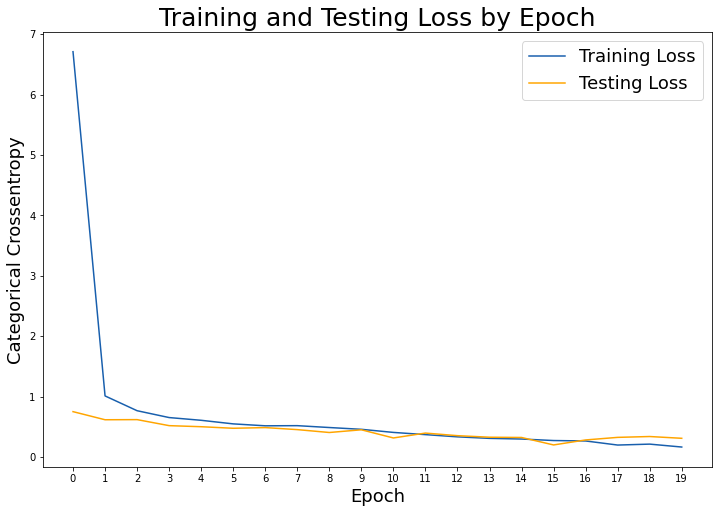

In [74]:
get_loss_vis(model_inter_area_6)

Confusion matrix, without normalization
[[43  7]
 [ 5 45]]


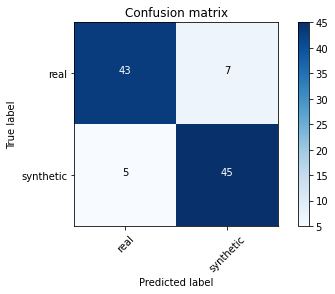

In [75]:
get_confusion(model_inter_area_6, test_batches)

In [76]:
# Experimenting with layer parameters


model_inter_area_7 = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)), # adjusted
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.35),
    Dense(64, activation='relu'),
    Dropout(.35),
    
    Dense(units=2, activation='softmax')
])

model_inter_area_7.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_7.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=20, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/20
50/50 [==============================] - 10s 168ms/step - loss: 3.1324 - accuracy: 0.5660 - val_loss: 0.7028 - val_accuracy: 0.5700
Epoch 2/20
50/50 [==============================] - 8s 159ms/step - loss: 0.7465 - accuracy: 0.5780 - val_loss: 0.5653 - val_accuracy: 0.7600
Epoch 3/20
50/50 [==============================] - 8s 159ms/step - loss: 0.6441 - accuracy: 0.6580 - val_loss: 0.5842 - val_accuracy: 0.7100
Epoch 4/20
50/50 [==============================] - 8s 158ms/step - loss: 0.6309 - accuracy: 0.6420 - val_loss: 0.5572 - val_accuracy: 0.7400
Epoch 5/20
50/50 [==============================] - 8s 159ms/step - loss: 0.5652 - accuracy: 0.7080 - val_loss: 0.5183 - val_accuracy: 0.7300
Epoch 6/20
50/50 [==============================] - 8s 159ms/step - loss: 0.5088 - accuracy: 0.7320 - val_loss: 0.4300 - val_accuracy: 0.8200
Epoch 7/20
50/50 [==============================] - 8s 159ms/step - loss: 0.4937 - accuracy: 0.7540 - val_loss: 0.4232 - val_accuracy: 0.8600
Epoch

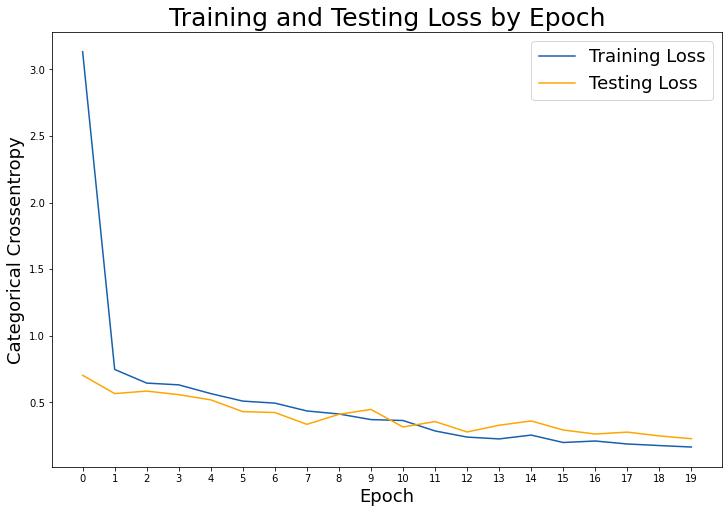

In [77]:
get_loss_vis(model_inter_area_7)

Confusion matrix, without normalization
[[38 12]
 [ 3 47]]


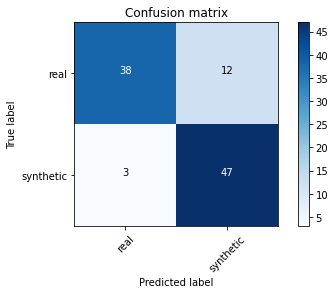

In [78]:
get_confusion(model_inter_area_7, test_batches)

In [89]:
# Experimenting with layer parameters


model_inter_area_8 = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.35),
    Dense(64, activation='relu'),
    Dropout(.35),
    Dense(16, activation='relu'), # added
    Dropout(.35), # added
    
    Dense(units=2, activation='softmax')
])

model_inter_area_8.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_8.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=30, # adjusted 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/30
50/50 [==============================] - 9s 169ms/step - loss: 2.0073 - accuracy: 0.5020 - val_loss: 0.6770 - val_accuracy: 0.6300
Epoch 2/30
50/50 [==============================] - 8s 160ms/step - loss: 0.7518 - accuracy: 0.5380 - val_loss: 0.6947 - val_accuracy: 0.5100
Epoch 3/30
50/50 [==============================] - 8s 159ms/step - loss: 0.7254 - accuracy: 0.5440 - val_loss: 0.6736 - val_accuracy: 0.5900
Epoch 4/30
50/50 [==============================] - 8s 159ms/step - loss: 0.7205 - accuracy: 0.5200 - val_loss: 0.6858 - val_accuracy: 0.5800
Epoch 5/30
50/50 [==============================] - 8s 160ms/step - loss: 0.6980 - accuracy: 0.5680 - val_loss: 0.6731 - val_accuracy: 0.6200
Epoch 6/30
50/50 [==============================] - 8s 160ms/step - loss: 0.6883 - accuracy: 0.5820 - val_loss: 0.6827 - val_accuracy: 0.5700
Epoch 7/30
50/50 [==============================] - 8s 160ms/step - loss: 0.6868 - accuracy: 0.5700 - val_loss: 0.6635 - val_accuracy: 0.5800
Epoch 

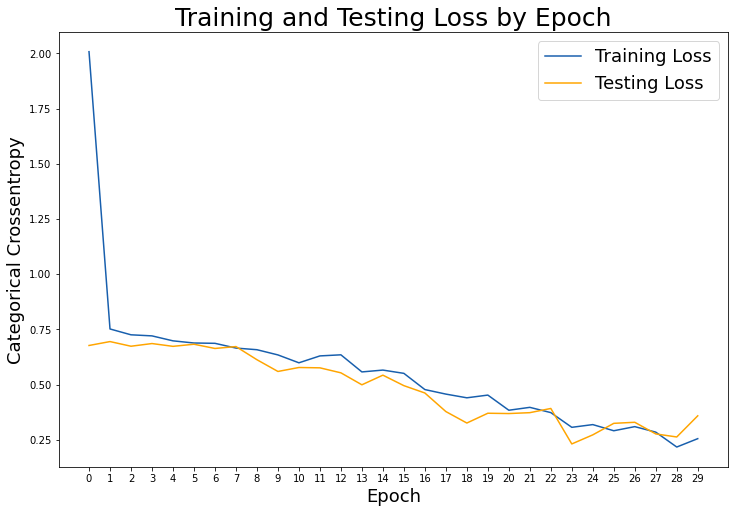

In [90]:
get_loss_vis(model_inter_area_8)

Confusion matrix, without normalization
[[44  6]
 [ 6 44]]


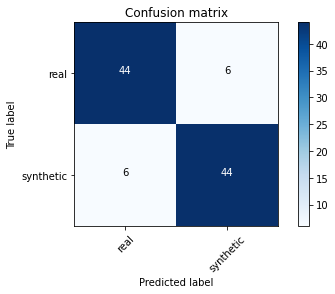

In [91]:
get_confusion(model_inter_area_8, test_batches)

In [82]:
model_inter_area_8.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 112, 112, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 28, 28, 32)     

In [92]:
# Experimenting with layer parameters


model_inter_area_9 = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'), # adjusted
    MaxPool2D(pool_size=(2, 2), strides=2), # adjusted
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.3), # adjusted
    Dense(16, activation='relu'), # adjusted
    Dropout(.3), # adjusted
    
    Dense(units=2, activation='softmax')
])

model_inter_area_9.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_9.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=20, # adjusted 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/20
50/50 [==============================] - 10s 184ms/step - loss: 3.9779 - accuracy: 0.4720 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/20
50/50 [==============================] - 9s 177ms/step - loss: 0.8076 - accuracy: 0.5200 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 3/20
50/50 [==============================] - 9s 177ms/step - loss: 0.7187 - accuracy: 0.4720 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
50/50 [==============================] - 9s 178ms/step - loss: 0.6980 - accuracy: 0.5200 - val_loss: 0.6857 - val_accuracy: 0.5500
Epoch 5/20
50/50 [==============================] - 9s 178ms/step - loss: 0.6872 - accuracy: 0.5480 - val_loss: 0.6750 - val_accuracy: 0.7200
Epoch 6/20
50/50 [==============================] - 9s 177ms/step - loss: 0.6851 - accuracy: 0.5660 - val_loss: 0.6412 - val_accuracy: 0.7700
Epoch 7/20
50/50 [==============================] - 9s 177ms/step - loss: 0.6508 - accuracy: 0.5960 - val_loss: 0.6040 - val_accuracy: 0.7600
Epoch

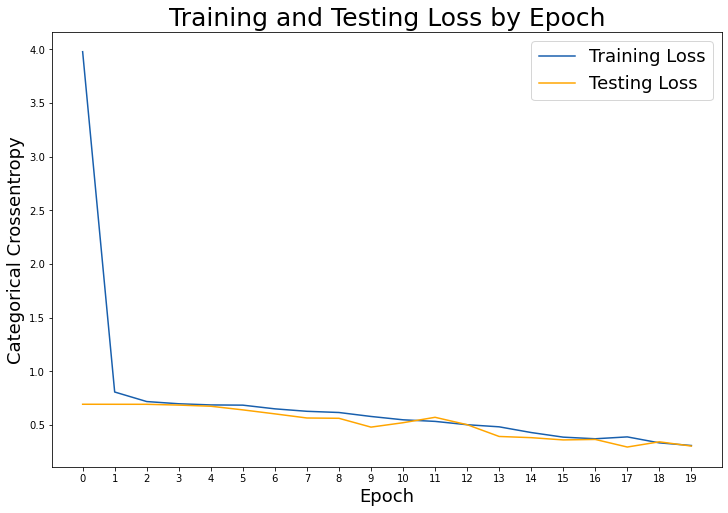

In [94]:
get_loss_vis(model_inter_area_9)

Confusion matrix, without normalization
[[45  5]
 [ 5 45]]


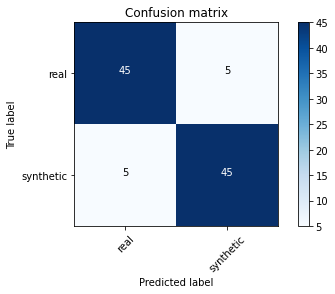

In [95]:
get_confusion(model_inter_area_9, test_batches)

In [96]:
# Experimenting with layer parameters


model_inter_area_10 = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),  # adjusted
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'), 
    MaxPool2D(pool_size=(2, 2), strides=2), # adjusted
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.3),
    Dense(16, activation='relu'),
    Dropout(.3),
    
    Dense(units=2, activation='softmax')
])

model_inter_area_10.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_10.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=20, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/20
50/50 [==============================] - 6s 96ms/step - loss: 39.6707 - accuracy: 0.4640 - val_loss: 3.1012 - val_accuracy: 0.6000
Epoch 2/20
50/50 [==============================] - 4s 89ms/step - loss: 8.3060 - accuracy: 0.5300 - val_loss: 1.3449 - val_accuracy: 0.5800
Epoch 3/20
50/50 [==============================] - 4s 88ms/step - loss: 1.3050 - accuracy: 0.5180 - val_loss: 0.6310 - val_accuracy: 0.5300
Epoch 4/20
50/50 [==============================] - 5s 90ms/step - loss: 0.7122 - accuracy: 0.5260 - val_loss: 0.6689 - val_accuracy: 0.4600
Epoch 5/20
50/50 [==============================] - 4s 89ms/step - loss: 0.6842 - accuracy: 0.5100 - val_loss: 0.6760 - val_accuracy: 0.5100
Epoch 6/20
50/50 [==============================] - 4s 88ms/step - loss: 0.7128 - accuracy: 0.5220 - val_loss: 0.6916 - val_accuracy: 0.4400
Epoch 7/20
50/50 [==============================] - 4s 88ms/step - loss: 0.7159 - accuracy: 0.4960 - val_loss: 0.6861 - val_accuracy: 0.5400
Epoch 8/20
5

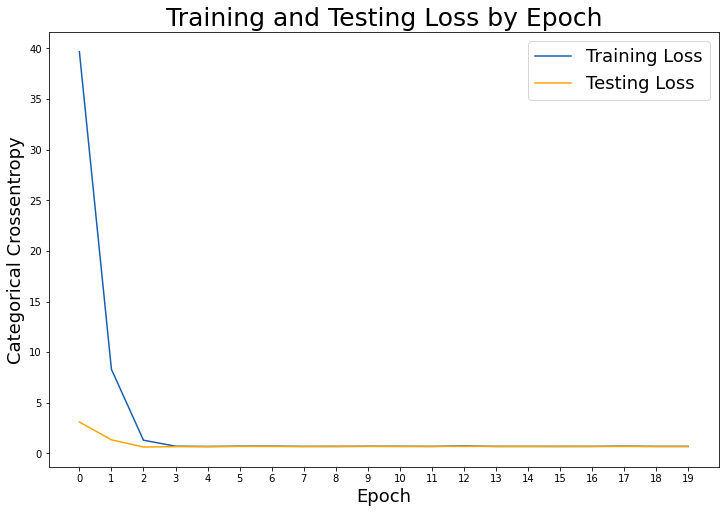

In [97]:
get_loss_vis(model_inter_area_10)

Confusion matrix, without normalization
[[ 0 50]
 [ 0 50]]


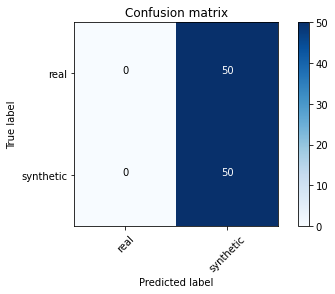

In [98]:
get_confusion(model_inter_area_10, test_batches)

Okay, this is a genuinely interesting result. I suspect that by significantly reducing the number of convolutional kernel filter nodes on the first layer, this collapsed the ability for the model to make any kind of appreciable assessment of the images and funneled the model down a path to which it couldn't recover (a very unperformant local minima that it could not escape).

In [100]:
# Experimenting with layer parameters


model_inter_area_11 = Sequential([
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'), #adjusted
    MaxPool2D(pool_size=(2, 2), strides=2), # adjusted
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(.3),
    Dense(16, activation='relu'),
    Dropout(.3),
    
    Dense(units=2, activation='softmax')
])

model_inter_area_11.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

time_0 = time.time()

model_inter_area_11.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=20, 
          verbose=1, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_17/conv2d_43/Conv2D' defined at (most recent call last):
    File "C:\Users\musou\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\musou\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\musou\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\musou\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\musou\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\musou\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\musou\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\musou\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\musou\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\musou\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\musou\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\musou\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\musou\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\musou\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\musou\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\musou\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\musou\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\musou\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\musou\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\musou\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\musou\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\musou\AppData\Local\Temp/ipykernel_5916/2894523519.py", line 23, in <module>
      model_inter_area_11.fit(x=train_batches,
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\musou\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_17/conv2d_43/Conv2D'
OOM when allocating tensor with shape[10,128,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_17/conv2d_43/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_98308]

In [ ]:
get_loss_vis(model_inter_area_10)

In [ ]:
get_confusion(model_inter_area_10, test_batches)